In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

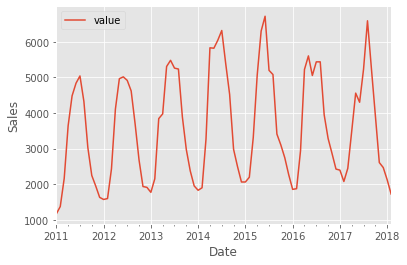

In [2]:
# Load the data
data = pd.read_excel(r'Time Series_MyData.xlsx',sheet_name = 'No.36 制汗體香劑 Deodorant', skipfooter=3)
# A bit of pre-processing to make it nicer
data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')
data.set_index(['date'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()

In [3]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[4], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 0, 0) x (1, 0, 0, 12)


In [4]:
train_data = data['2011-01-01':'2017-12-01']
test_data = data['2018-01-01':'2018-05-01']

In [5]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [6]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 509.34397625515896 for model SARIMAX(3, 1, 1)x(3, 1, 1, 12)


In [7]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

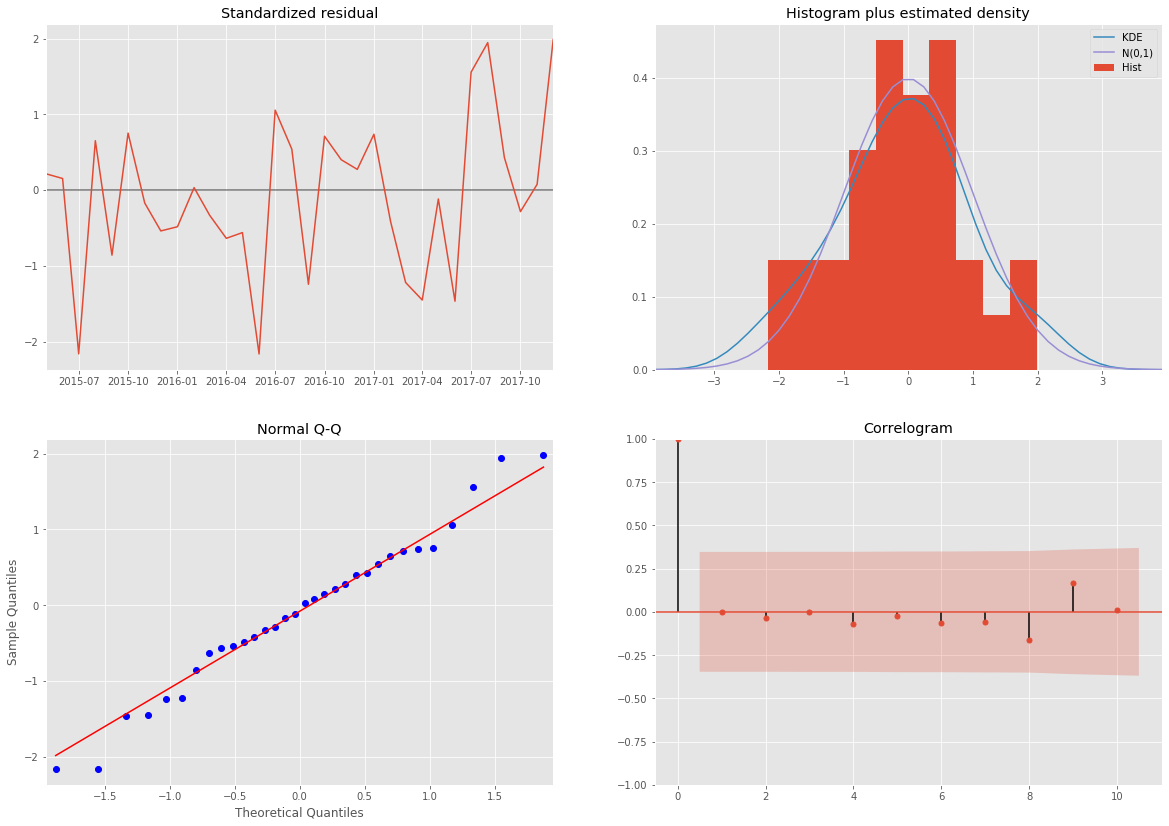

In [8]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [9]:
pred0 = results.get_prediction(start='2015-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [10]:
pred1 = results.get_prediction(start='2015-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [11]:
pred2 = results.get_forecast('2020-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2018-01-01':'2018-05-01'])

2018-01-01    2072.470061
2018-02-01    2005.243687
2018-03-01    2673.086617
2018-04-01    4474.360333
2018-05-01    5239.297552
Freq: MS, dtype: float64


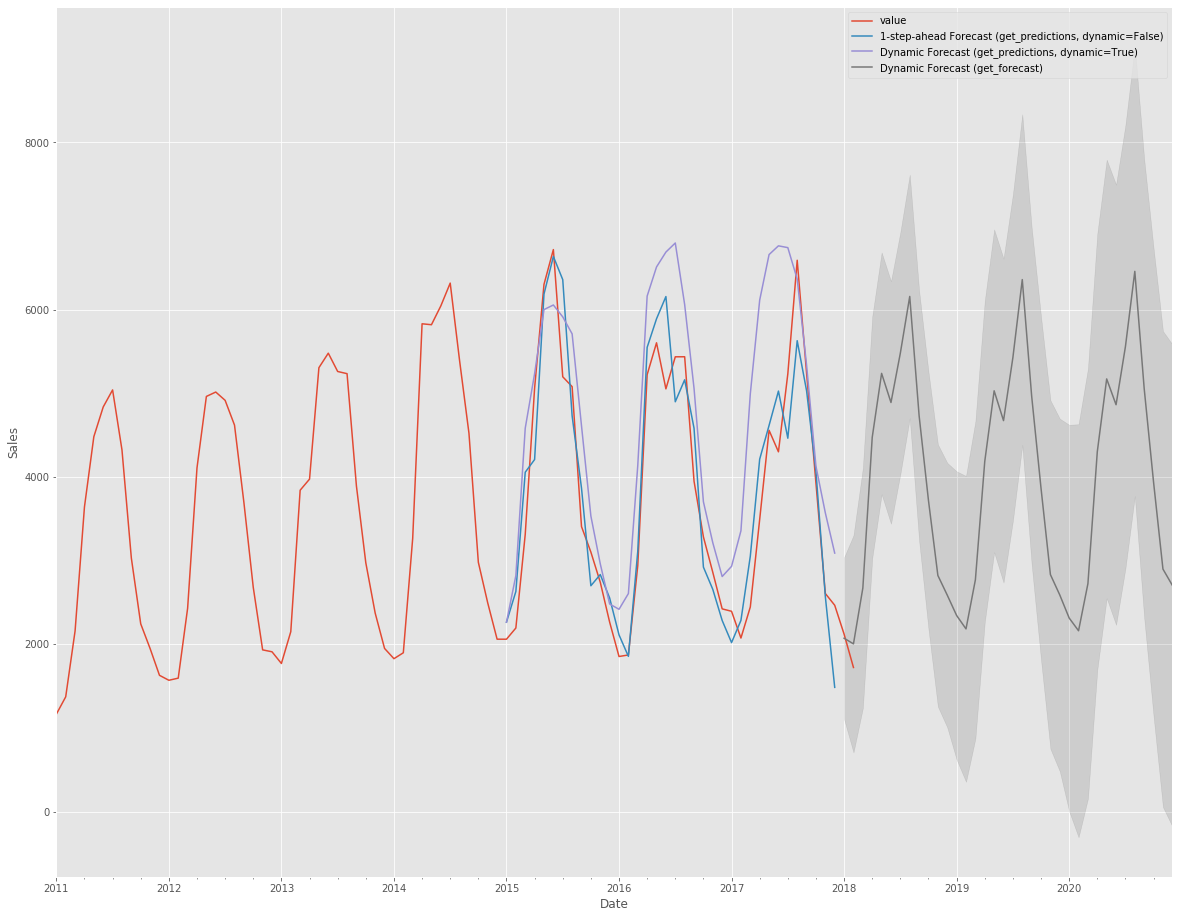

In [12]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend()
plt.show()

In [13]:
froecast_2017to2020 = {'Predicted': pred2.predicted_mean, 'LCL': pred2_ci.iloc[:, 0], 'UCL': pred2_ci.iloc[:, 1]}
df_froecast_2017to2020 = pd.DataFrame(data=froecast_2017to2020)
df_froecast_2017to2020

,Predicted,LCL,UCL
2018-01-01,2072.470061,1104.860995,3040.079128
2018-02-01,2005.243687,707.034048,3303.453326
2018-03-01,2673.086617,1237.759921,4108.413312
2018-04-01,4474.360333,3030.434519,5918.286147
2018-05-01,5239.297552,3793.358181,6685.236923
2018-06-01,4891.041766,3441.003650,6341.079882
2018-07-01,5482.435333,4036.610344,6928.260323
2018-08-01,6159.093431,4702.736205,7615.450656
2018-09-01,4732.941200,3238.940139,6226.942260
2018-10-01,3717.295118,2179.364061,5255.226174


In [14]:
import xlwings as xw

wb = xw.Book()
sheet = wb.sheets[0]
sheet.range("A1").value = df_froecast_2017to2020
wb.save("36")